# Third Party Library

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR

# Data Reading

In [92]:
registered_ev_file_path = 'Electric_Vehicle_Population_Data.csv'
ev_charging_station_file_path = 'EV_Charging_Station_Data.csv'

Reading Electric_Vehicle_Population_Data.csv file

In [93]:
name = ['City', 'State', 'Postal_Code', 'Vehicle Location']
df_registered_ev = pd.read_csv(registered_ev_file_path, usecols=name)

Sample data from Electric_Vehicle_Population_Data.csv file

In [94]:
df_registered_ev.head(5)

,City,State,Postal_Code,Vehicle Location
0,Seabeck,WA,98380.0,POINT (-122.8728334 47.5798304)
1,Bremerton,WA,98312.0,POINT (-122.6961203 47.5759584)
2,Seattle,WA,98101.0,POINT (-122.3340795 47.6099315)
3,Seattle,WA,98125.0,POINT (-122.304356 47.715668)
4,Yelm,WA,98597.0,POINT (-122.5715761 46.9095798)


Reading EV_Charging_Station_Data.csv file

In [95]:
name = ['City', 'State', 'Postal_Code', 'Charging Station Location', 'Charge_Stands']
df_ev_charging_station = pd.read_csv(ev_charging_station_file_path, usecols=name)

Sample data from EV_Charging_Station_Data.csv file

In [96]:
df_ev_charging_station.head(5)

,City,State,Postal_Code,Charging Station Location,Charge_Stands
0,Poulsbo,WA,98370,"47.7774056426997, -122.65904131849484",2
1,Poulsbo,WA,98370,"47.76263764284079, -122.6617879004727",8
2,Poulsbo,WA,98370,"47.746480341201085, -122.64805499058342",4
3,Suquamish,WA,98392,"47.72523740012811, -122.56565753211538",12
4,Poulsbo,WA,98370,"47.76204317882462, -122.65028819485335",2


# Data Processing

### Data Processing Function

In [97]:
def add_charging_station_density_within_1_mile_radiu(df_ev_charging_station):
    radius_miles = 1
    radius_radians = radius_miles / 3958.8

    # Fit NearestNeighbors to charging stations
    nbrs = NearestNeighbors(radius=radius_radians, metric='haversine')
    charging_coordinates = np.radians(df_ev_charging_station[['Latitude', 'Longitude']].values)
    nbrs.fit(charging_coordinates)
    counts = nbrs.radius_neighbors(charging_coordinates, return_distance=False)

    # Add the counts to df_ev_charging_station
    df_ev_charging_station['Charge_Station_Within_Mile'] = [(len(count)-1) for count in counts]

In [98]:
def add_ev_density_within_1_mile_radiu(df_ev_charging_station, df_registered_ev):
    radius_miles = 1
    radius_radians = radius_miles / 3958.8
    registered_ev_coordinates = np.radians(df_registered_ev[['Latitude', 'Longitude']].values)
    charging_station_coordinates = np.radians(df_ev_charging_station[['Latitude', 'Longitude']].values)
    nbrs = NearestNeighbors(radius=radius_radians, metric='haversine')
    nbrs.fit(registered_ev_coordinates)
    
    # Count the number of nearby EV for each charging stations
    counts = nbrs.radius_neighbors(charging_station_coordinates, return_distance=False)
    
    # Add the counts to df_ev_charging_station
    df_ev_charging_station['EV_Count_Within_Mile'] = [len(count) for count in counts]

### Clean The Data

- Check for NA value:

In [99]:
df_registered_ev.isna().sum()

City                3
State               0
Postal_Code         3
Vehicle Location    8
dtype: int64

In [100]:
df_ev_charging_station.isna().sum()

City                         0
State                        0
Postal_Code                  0
Charging Station Location    0
Charge_Stands                0
dtype: int64

- Check and update invalid values in DataFrame:

In [101]:
df_registered_ev.query("State != 'WA'")

,City,State,Postal_Code,Vehicle Location
26697,Platte City,MO,64079.0,POINT (-94.7758051 39.3549561)
33457,Seaside,CA,93955.0,POINT (-121.831434 36.614732)
38814,Norfolk,VA,23503.0,POINT (-76.251684 36.942546)
40765,Fayetteville,NC,28312.0,POINT (-78.780926 35.019816)
42678,Upper Marlboro,MD,20774.0,POINT (-76.8100874 38.8903361)
...,...,...,...,...
204210,San Antonio,TX,78261.0,POINT (-98.4154843 29.6721151)
204576,Coronado,CA,92118.0,POINT (-117.170566 32.684631)
204733,Colorado Springs,CO,80906.0,POINT (-104.819948 38.788438)
205115,Greenfield Center,NY,12833.0,POINT (-73.845094 43.12833)


In [102]:
df_registered_ev.drop(df_registered_ev[df_registered_ev['State'] != 'WA'].index, inplace=True)

In [103]:
df_registered_ev[df_registered_ev['Vehicle Location'].isna()]

,City,State,Postal_Code,Vehicle Location
138046,Long Beach,WA,98634.0,NaN
148503,Long Beach,WA,98634.0,NaN
176278,Long Beach,WA,98634.0,NaN
178268,Long Beach,WA,98634.0,NaN
178396,Long Beach,WA,98634.0,NaN


In [104]:
df_registered_ev = df_registered_ev.dropna(subset=['Vehicle Location'])

In [105]:
df_registered_ev.isna().sum()

City                0
State               0
Postal_Code         0
Vehicle Location    0
dtype: int64

### Transform TheData

- Covert location into Longitude and Latitude

In [106]:
# Extract Longitude and Latitude from 'Vehicle Location'
df_registered_ev[['Longitude', 'Latitude']] = df_registered_ev['Vehicle Location'].str.extract(
    r'POINT \(([^ ]+) 'r'([^ ]+)\)')

In [107]:
# Extract Longitude and Latitude from 'Charging Station Location'
df_ev_charging_station[['Latitude', 'Longitude']] = df_ev_charging_station['Charging Station Location'].str.extract(
    r'([\d.-]+), ([\d.-]+)')

In [108]:
df_registered_ev = df_registered_ev.drop(columns=['Vehicle Location'])
df_ev_charging_station = df_ev_charging_station.drop(columns=['Charging Station Location'])

In [109]:
# Transfer correct data type for the columns
df_registered_ev['Postal_Code'] = df_registered_ev['Postal_Code'].astype(int)
df_registered_ev['Latitude'] = pd.to_numeric(df_registered_ev['Latitude'], errors='coerce')
df_registered_ev['Longitude'] = pd.to_numeric(df_registered_ev['Longitude'], errors='coerce')
df_ev_charging_station['Latitude'] = pd.to_numeric(df_ev_charging_station['Latitude'], errors='coerce')
df_ev_charging_station['Longitude'] = pd.to_numeric(df_ev_charging_station['Longitude'], errors='coerce')

    Distribution of Registered EV and Charging Station

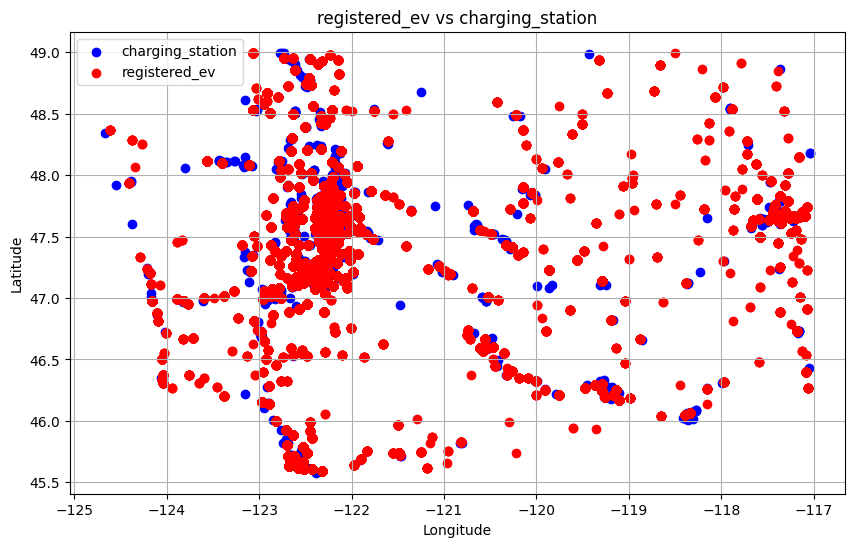

In [110]:
# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot the first set of coordinates
plt.scatter(df_ev_charging_station['Longitude'], df_ev_charging_station['Latitude'], color='blue', label='charging_station')

# Plot the second set of coordinates
plt.scatter(df_registered_ev['Longitude'], df_registered_ev['Latitude'], color='red', label='registered_ev')

# Add labels and title
plt.title('registered_ev vs charging_station')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend
plt.legend()

# Show the plot
plt.grid()
plt.show()

- Feature Engineering:

In [111]:
df_ev_charging_station['Charge_Stations_Postal'] = df_ev_charging_station.groupby(['City', 'State', 'Postal_Code']).transform('size')
charging_station_total = df_ev_charging_station.groupby(['City', 'State'])['Charge_Stations_Postal'].sum().reset_index(name='Charge_Stations_City')
df_ev_charging_station = pd.merge(df_ev_charging_station, charging_station_total, on=['City', 'State'], how='left')

In [112]:
df_ev_charging_station['Charge_Stands_City'] = df_ev_charging_station.groupby(['City', 'State', 'Postal_Code'])['Charge_Stands'].transform('sum')

In [113]:
ev_count = df_registered_ev.groupby(['City', 'State', 'Postal_Code']).size().reset_index(name='EV_Count_Postal')
ev_count_total = ev_count.groupby(['City', 'State'])['EV_Count_Postal'].sum().reset_index(name='EV_Count_City')
ev_count = pd.merge(ev_count_total, ev_count, on=['City', 'State'], how='left')

In [114]:
# Merge EV Count
df_ev_charging_station = pd.merge(df_ev_charging_station, ev_count, on=['City', 'State', 'Postal_Code'], how='left')
# Check For NA values
df_ev_charging_station.isna().sum()

City                       0
State                      0
Postal_Code                0
Charge_Stands              0
Latitude                   0
Longitude                  0
Charge_Stations_Postal     0
Charge_Stations_City       0
Charge_Stands_City         0
EV_Count_City             24
EV_Count_Postal           24
dtype: int64

In [115]:
# replace NA with 0
df_ev_charging_station.fillna({'EV_Count_Postal': 0,'EV_Count_City': 0}, inplace=True)
df_ev_charging_station.isna().sum()

City                      0
State                     0
Postal_Code               0
Charge_Stands             0
Latitude                  0
Longitude                 0
Charge_Stations_Postal    0
Charge_Stations_City      0
Charge_Stands_City        0
EV_Count_City             0
EV_Count_Postal           0
dtype: int64

In [116]:
df_ev_charging_station['EV_Count_Postal']=df_ev_charging_station['EV_Count_Postal'].astype(int)
df_ev_charging_station['EV_Count_City']=df_ev_charging_station['EV_Count_City'].astype(int)

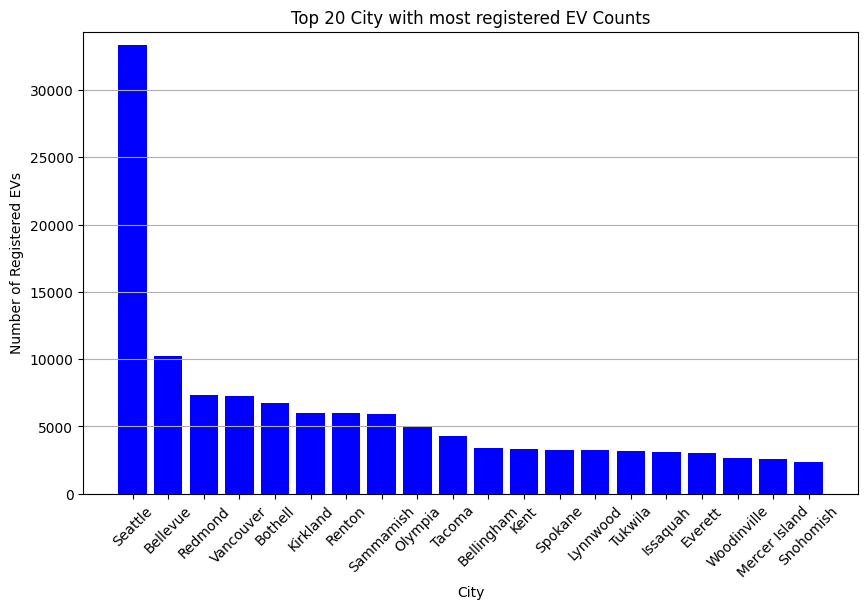

In [117]:
combine_df = pd.merge(ev_count_total, charging_station_total, on=['City'], how='left')
combine_df = combine_df[['City', 'EV_Count_City', 'Charge_Stations_City']]
combine_df.fillna({'EV_Count_City': 0,'Charge_Stations_City': 0}, inplace=True)
combine_df['Charge_Stations_City']=combine_df['Charge_Stations_City'].astype(int)

sorted_df = combine_df.sort_values(by='EV_Count_City', ascending=False)
sorted_df = sorted_df.head(20)

plt.figure(figsize=(10, 6))
plt.bar(sorted_df['City'], sorted_df['EV_Count_City'], color='blue')

# Step 3: Customize the plot
plt.title('Top 20 City with most registered EV Counts')
plt.xlabel('City')
plt.ylabel('Number of Registered EVs')
plt.xticks(rotation=45)  # Rotate city names for better readability
plt.grid(axis='y')

# Step 4: Show the plot
plt.ylim(0, max(sorted_df['EV_Count_City']) + 1000)  # Adjust y-axis limit
plt.show()

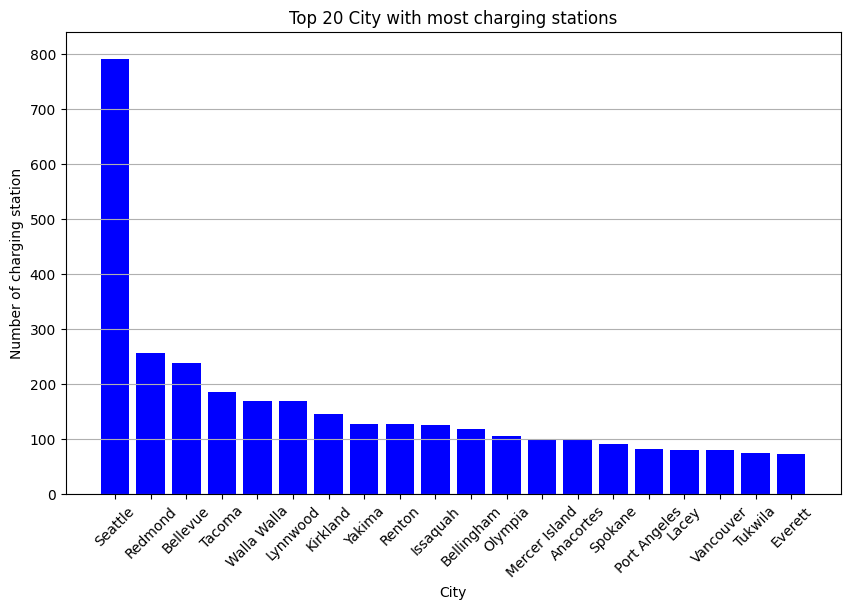

In [118]:
sorted_df = combine_df.sort_values(by='Charge_Stations_City', ascending=False)
sorted_df = sorted_df.head(20)

plt.figure(figsize=(10, 6))
plt.bar(sorted_df['City'], sorted_df['Charge_Stations_City'], color='blue')

# Step 3: Customize the plot
plt.title('Top 20 City with most charging stations')
plt.xlabel('City')
plt.ylabel('Number of charging station')
plt.xticks(rotation=45)  # Rotate city names for better readability
plt.grid(axis='y')

# Step 4: Show the plot
plt.ylim(0, max(sorted_df['Charge_Stations_City']) + 50)  # Adjust y-axis limit
plt.show()

In [119]:
add_charging_station_density_within_1_mile_radiu(df_ev_charging_station)

In [120]:
add_ev_density_within_1_mile_radiu(df_ev_charging_station, df_registered_ev)

In [121]:
df_ev_charging_station = df_ev_charging_station.drop(columns=['State'])

- Using one hot encoder to transfer city into numeric data

In [122]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

In [123]:
transformed_df_ev_charging_station = ohe.fit_transform(df_ev_charging_station[['City']])
transformed_df_ev_charging_station = pd.concat([transformed_df_ev_charging_station, df_ev_charging_station], axis=1)

In [124]:
df_ev_charging_station.head(5)

,City,Postal_Code,Charge_Stands,Latitude,Longitude,Charge_Stations_Postal,Charge_Stations_City,Charge_Stands_City,EV_Count_City,EV_Count_Postal,Charge_Station_Within_Mile,EV_Count_Within_Mile
0,Poulsbo,98370,2,47.777406,-122.659041,7,49,24,840,839,0,0
1,Poulsbo,98370,8,47.762638,-122.661788,7,49,24,840,839,1,0
2,Poulsbo,98370,4,47.746480,-122.648055,7,49,24,840,839,3,850
3,Suquamish,98392,12,47.725237,-122.565658,2,4,14,77,77,0,78
4,Poulsbo,98370,2,47.762043,-122.650288,7,49,24,840,839,1,0


### Split The Data

In [125]:
y = transformed_df_ev_charging_station[['Latitude','Longitude']]
X = transformed_df_ev_charging_station.drop(columns=['Latitude','Longitude','City'])

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

In [127]:
svr_model = MultiOutputRegressor(SVR(kernel='rbf'))

In [128]:
svr_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

# Model Evaluation

In [129]:
y_pred = svr_model.predict(X_test)

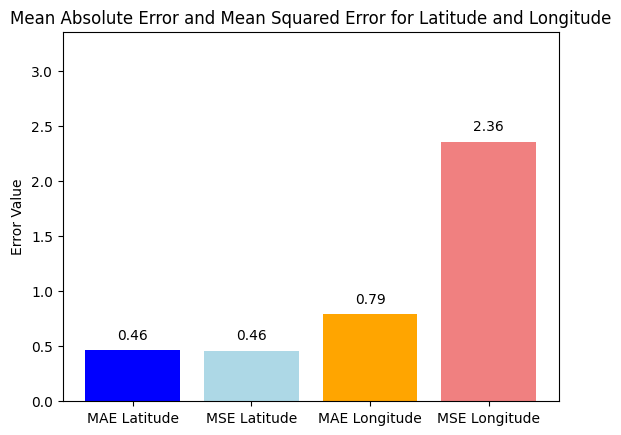

In [130]:
mae_latitude = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])
mse_latitude = mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0])

mae_longitude = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])
mse_longitude = mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1])

metrics = ['MAE Latitude', 'MSE Latitude', 'MAE Longitude', 'MSE Longitude']
values = [mae_latitude, mse_latitude, mae_longitude, mse_longitude]

plt.bar(metrics, values, color=['blue', 'lightblue', 'orange', 'lightcoral'])
plt.title('Mean Absolute Error and Mean Squared Error for Latitude and Longitude')
plt.ylabel('Error Value')
plt.ylim(0, max(values) + 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.show()

# Model Prediction

In [131]:
# Function to create a custom labeled widget
def create_labeled_widget(widget, label, alignment='left'):
    label_html = f"<div style='text-align: {alignment};'>{label}</div>"
    return widgets.VBox([widgets.HTML(value=label_html), widget])

# Create input widgets with left alignment
dropdown = create_labeled_widget(
    widgets.Dropdown(
        options=df_ev_charging_station['City'].unique(),
        disabled=False,
    ),
    'Select a city:',
    alignment='left'
)

postal_code_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter postal code',
        layout={'width': '300px'}
    ),
    'Postal_Code:',
    alignment='left'
)

charge_stand_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter total charge stands',
        layout={'width': '300px'}
    ),
    'Charge_Stands:',
    alignment='left'
)

charge_stand_count_in_city_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter charge stand count',
        layout={'width': '300px'}
    ),
    'Charge_Stands_City:',
    alignment='left'
)

charge_station_in_postal_code_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter charge station count',
        layout={'width': '300px'}
    ),
    'Charge_Stations_Postal:',
    alignment='left'
)

charge_station_in_city_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter charge station count',
        layout={'width': '300px'}
    ),
    'Charge_Stations_City:',
    alignment='left'
)

ev_count_in_postal_code_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter registered EV count',
        layout={'width': '300px'}
    ),
    'EV_Count_Postal:',
    alignment='left'
)

ev_count_in_city_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter registered EV count',
        layout={'width': '300px'}
    ),
    'EV_Count_City:',
    alignment='left'
)

ev_count_in_city_within_mile_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter registered EV count',
        layout={'width': '300px'}
    ),
    'EV_Count_Within_Mile:',
    alignment='left'
)

charge_station_within_mile_input = create_labeled_widget(
    widgets.IntText(
        placeholder='Enter charge station count',
        layout={'width': '300px'}
    ),
    'Charge_Station_Within_Mile:',
    alignment='left'
)

predict_button = widgets.Button(
    description='Predict'
)

# Create an error message label
error_label = widgets.Label(value="", layout={'width': '300px', 'color': 'red'})

output = widgets.Output()

frame = widgets.VBox([
    widgets.HTML(value="<h3 style='text-align: left;'>Predicting New EV Charging Station Location</h3>"),
    dropdown,
    postal_code_input,
    charge_stand_input,
    charge_stand_count_in_city_input,
    charge_station_in_postal_code_input,
    charge_station_in_city_input,
    ev_count_in_postal_code_input,
    ev_count_in_city_input,
    ev_count_in_city_within_mile_input,
    charge_station_within_mile_input,
    predict_button,
    output
])

new_predict = pd.DataFrame(columns=X.columns)

# Link the button to the prediction function
def on_button_click(b):
    # Gather inputs
    city = ('City_'+dropdown.children[1].value).rstrip() # Access the dropdown value
    postal_code = postal_code_input.children[1].value
    charge_stands = charge_stand_input.children[1].value
    charge_stands_city = charge_stand_count_in_city_input.children[1].value
    charge_stations_postal = charge_station_in_postal_code_input.children[1].value
    charge_stations_city = charge_station_in_city_input.children[1].value
    ev_count_postal = ev_count_in_postal_code_input.children[1].value
    ev_count_city = ev_count_in_city_input.children[1].value
    ev_count_within_mile = ev_count_in_city_within_mile_input.children[1].value
    charge_station_within_mile = charge_station_within_mile_input.children[1].value
    
    # Prepare the new DataFrame for prediction
    new_predict.loc[0]={city:1 ,'Postal_Code':postal_code,'Charge_Stands':charge_stands,'Charge_Stands_City':charge_stands_city,
                        'Charge_Stations_Postal':charge_stations_postal,'Charge_Stations_City':charge_stations_city,
                        'EV_Count_City':ev_count_city,'EV_Count_Postal':ev_count_postal,'Charge_Station_Within_Mile':charge_station_within_mile,'EV_Count_Within_Mile':ev_count_within_mile
        }

    new_predict.fillna(0, inplace=True)
    						
    # Predict using your model (replace svr_model with your actual model)
    result = svr_model.predict(new_predict)
    latitude = result[:, 0]
    longitude = result[:, 1]
    # Output the result
    with output:
        output.clear_output()  # Clear previous output
        print(f"Prediction Result: Latitude = {latitude}, Longitude = {longitude}")


predict_button.on_click(on_button_click)

# Display the widgets
display(frame)